In [1]:
#%cd pygcn
import pylab as plt
from __future__ import division
from __future__ import print_function
from torch.autograd import Variable
from collections import defaultdict, Counter
from scipy import spatial
import matplotlib.cm as cm
import random
from scipy.stats.stats import pearsonr
from scipy.stats.mstats import zscore
import statsmodels.api as sm
import glob
import os

import networkx as nx
import time
import math
import argparse
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from pygcn.layers import GraphConvolution
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module

#from pygcn.utils import load_data, accuracy
#from pygcn.models import GCN

import sys

def flushPrint(www):
    sys.stdout.write('\r')
    sys.stdout.write('%s' % www)
    sys.stdout.flush()

### prepare feature data

In [64]:
Job={}
with open('/Users/lingfeiw/Documents/research/KatyPNAS/db_22_1_text/Occupation Data.txt','r') as f:
    for line in f:
        line=line.strip().split('\t')
        if line[0][-1].isdigit():#remove the variable name row
            Job[line[0]]=line[1]#job code, title

J=defaultdict(lambda:defaultdict(lambda:0))
K=defaultdict(lambda:defaultdict(lambda:0))

with open('/Users/lingfeiw/Documents/research/KatyPNAS/db_22_1_text/Skills.txt','r') as f:
    for line in f:
        line=line.strip().split('\t')
        if line[0][-1].isdigit():#remove the variable name row
            if line[3]=='IM':#importance scale 
                J[Job[line[0]]][line[2]]=float(line[4])#job name: skill: importance score          
with open('/Users/lingfeiw/Documents/research/KatyPNAS/db_22_1_text/Knowledge.txt','r') as f:
    for line in f:
        line=line.strip().split('\t')
        if line[0][-1].isdigit():#remove the variable name row
            if line[3]=='IM':#importance scale 
                K[Job[line[0]]][line[2]]=float(line[4])#job name: knowledge: importance score    
J=dict(J)
K=dict(K)



JC={}
with open('/Users/lingfeiw/Documents/research/KatyPNAS/db_22_1_text/Occupation Data.txt','r') as f:
    for line in f:
        line=line.strip().split('\t')
        if line[0][-1].isdigit():#remove the variable name row
            JC[line[0]]=line[1]#job code, title
            
L={}
n=0
with open('/Users/lingfeiw/Documents/research/KatyPNAS/rank_probability_label_soc_occupation.txt','r') as f:
    for line in f:
        rank,pro,label,jobcode,jobname=line.strip().split('\t')
        if label:
            L[jobname]=int(label)
            
len(JC),len(K)#1110, 966

(1110, 966)

In [4]:
'''

# construct automation vulnerability features
with open('/Users/lingfeiw/Documents/research/people2vec/pygcn-master/data/onet/jobCodes.txt', 'w') as f:
    for j in J:
        scores=list(K[j].values())+list(J[j].values())
        if j in L:
            label=L[j]
        else:
            label=2
        f.write(j+'\t'+'\t'.join(map(str,scores))+'\t'+str(label)+'\n')

'''

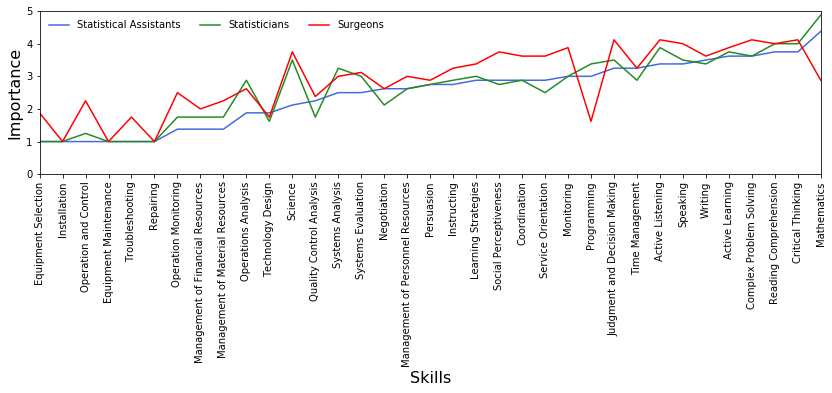

In [3]:
#data illustration
skills=list(zip(*sorted(J['Statistical Assistants'].items(),key=lambda x:x[1])))[0]
cmap = cm.get_cmap('rainbow',10)
fig = plt.figure(figsize=(14, 3),facecolor='white')
ax = fig.add_subplot(111)
plt.plot([J['Statistical Assistants'][j] for j in skills],color='RoyalBlue',label='Statistical Assistants')
plt.plot([J['Statisticians'][j] for j in skills],color='ForestGreen',label='Statisticians')
plt.plot([J['Surgeons'][j] for j in skills],color='r',label='Surgeons')
plt.xlabel('Skills',size=16)
plt.ylabel('Importance',size=16)
plt.legend(loc=2,ncol=6,frameon=False,fontsize=10)
plt.xticks(range(35))
plt.xlim(0,34)
plt.ylim(0,5)
ax.set_xticklabels(skills,rotation=90)

plt.show()

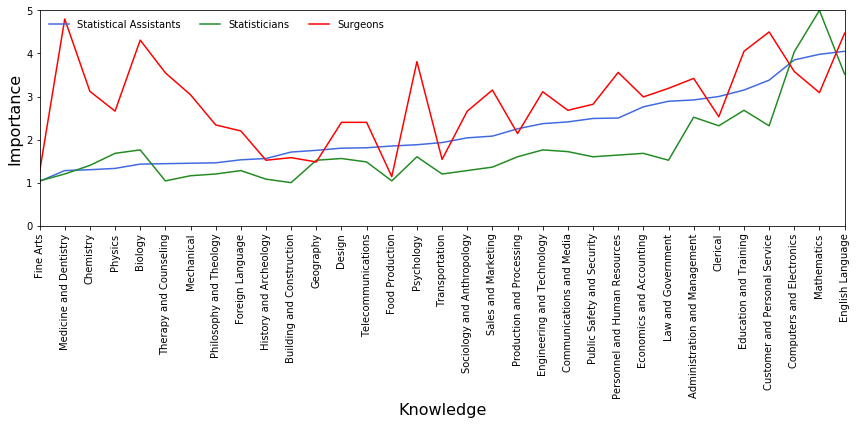

In [4]:
knowledge=list(zip(*sorted(K['Statistical Assistants'].items(),key=lambda x:x[1])))[0]
cmap = cm.get_cmap('rainbow',10)
fig = plt.figure(figsize=(12, 6),facecolor='white')
ax = fig.add_subplot(111)
plt.plot([K['Statistical Assistants'][j] for j in knowledge],color='RoyalBlue',label='Statistical Assistants')
plt.plot([K['Statisticians'][j] for j in knowledge],color='ForestGreen',label='Statisticians')
plt.plot([K['Surgeons'][j] for j in knowledge],color='r',label='Surgeons')
plt.xlabel('Knowledge',size=16)
plt.ylabel('Importance',size=16)
plt.legend(loc=2,ncol=6,frameon=False,fontsize=10)
plt.xticks(range(33))
plt.xlim(0,32)
plt.ylim(0,5)
ax.set_xticklabels(knowledge,rotation=90)
plt.tight_layout()

### prepare citation data

In [77]:
'''
jobs=sorted(set(Job.values()).intersection(K.keys()))
len(jobs)#966

E=defaultdict(lambda:{})
n=0
for i in jobs:
    n+=1
    if n%10==0:
        flushPrint(n)#960
    scorei=list(K[i].values())+list(J[i].values())
    for j in jobs:
        if j!=i:
            scorej=list(K[j].values())+list(J[j].values())
            r = 1 - spatial.distance.cosine(scorei, scorej)
            E[i][j]=r 
            
G=nx.Graph()
for i in E:
    for j in E[i]:
        w=E[i][j]
        if w>0.984:
            G.add_edge(i,j)
for i in jobs:
    if i not in G:
        j=sorted(E[i].items(),key=lambda x:-x[1])[0][0]
        k=sorted(E[i].items(),key=lambda x:-x[1])[1][0]
        G.add_edge(i,j)
        G.add_edge(i,k)
        
len(G),len(G.edges),nx.number_connected_components(G)

with open('/Users/lingfeiw/Documents/research/people2vec/pygcn-master/data/onet/jobCites.txt', 'w') as f:
    for i,j in G.edges():
        f.write(i+'\t'+j+'\n')
'''

966

### import data

In [17]:
def encode_onehot(labels):
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in
                    enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)),
                             dtype=np.int32)
    return labels_onehot

def normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)


def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).double()
    correct = correct.sum()
    return correct / len(labels)

In [475]:
path1="/Users/lingfeiw/Documents/research/people2vec/pygcn-master/data/onet/jobCodes.txt"
path2="/Users/lingfeiw/Documents/research/people2vec/pygcn-master/data/onet/jobCites.txt"

d=[]
with open(path1,'r') as f:
    for line in f:
        line=line.strip().split('\t')  
        d.append(line)
d=sorted(d,key=lambda x:x[-1])
d1=d[:70]
random.shuffle(d1)
d[:70]=d1
idx_features_labels=np.array(d)

In [476]:
idx_features_labels[:70, -1]

array(['1', '0', '0', '1', '0', '1', '0', '0', '0', '0', '1', '0', '0',
       '0', '1', '0', '1', '1', '0', '1', '1', '1', '0', '1', '0', '1',
       '1', '1', '0', '1', '0', '1', '0', '1', '1', '0', '0', '0', '1',
       '1', '1', '1', '1', '0', '1', '1', '0', '0', '1', '1', '1', '1',
       '0', '1', '0', '0', '1', '0', '1', '0', '0', '1', '1', '0', '1',
       '1', '0', '1', '0', '0'], dtype='<U105')

In [477]:
features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)
labels = encode_onehot(idx_features_labels[:, -1])#0--->001, 1---->010, 2---->100
NJ=dict((j,n) for n,j in enumerate(idx_features_labels[:, 0]))
# build graph
idx = np.array([NJ[j] for j in idx_features_labels[:, 0]], dtype=np.int32)
edges=[]
with open(path2,'r') as f:
    for line in f:
        i,j=line.strip().split('\t')  
        edges.append([NJ[i],NJ[j]])
edges=np.array(edges)
adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                    shape=(labels.shape[0], labels.shape[0]),
                    dtype=np.float32)
# build symmetric adjacency matrix
adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
features = normalize(features)
adj = normalize(adj + sp.eye(adj.shape[0]))

idx_train = range(40)
idx_val = range(40,55)
idx_test = range(55, 70)

features = torch.FloatTensor(np.array(features.todense()))
labels = torch.LongTensor(np.where(labels)[1])
adj = sparse_mx_to_torch_sparse_tensor(adj)

idx_train = torch.LongTensor(idx_train)
idx_val = torch.LongTensor(idx_val)
idx_test = torch.LongTensor(idx_test)

In [478]:
adj.shape,features.shape,labels.shape,idx_train.shape,idx_val.shape,idx_test.shape,set(labels.numpy())

(torch.Size([966, 966]),
 torch.Size([966, 68]),
 torch.Size([966]),
 torch.Size([40]),
 torch.Size([15]),
 torch.Size([15]),
 {0, 1, 2})

In [456]:


'''

path="/Users/lingfeiw/Documents/research/people2vec/pygcn-master/data/cora/"
dataset="cora"
idx_features_labels = np.genfromtxt("{}{}.content".format(path, dataset),
                                        dtype=np.dtype(str))

def load_data(path="/Users/lingfeiw/Documents/research/people2vec/pygcn-master/data/cora/", dataset="cora"):
    """Load citation network dataset (cora only for now)"""
    print('Loading {} dataset...'.format(dataset))

    idx_features_labels = np.genfromtxt("{}{}.content".format(path, dataset),
                                        dtype=np.dtype(str))
    features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)
    labels = encode_onehot(idx_features_labels[:, -1])

    # build graph
    idx = np.array(idx_features_labels[:, 0], dtype=np.int32)
    idx_map = {j: i for i, j in enumerate(idx)}
    edges_unordered = np.genfromtxt("{}{}.cites".format(path, dataset),
                                    dtype=np.int32)
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
                     dtype=np.int32).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                        shape=(labels.shape[0], labels.shape[0]),
                        dtype=np.float32)

    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    features = normalize(features)
    adj = normalize(adj + sp.eye(adj.shape[0]))

    idx_train = range(140)
    idx_val = range(200, 500)
    idx_test = range(500, 1500)

    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(np.where(labels)[1])
    adj = sparse_mx_to_torch_sparse_tensor(adj)

    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)
    idx_test = torch.LongTensor(idx_test)

    return adj, features, labels, idx_train, idx_val, idx_test
'''

'\n\npath="/Users/lingfeiw/Documents/research/people2vec/pygcn-master/data/cora/"\ndataset="cora"\nidx_features_labels = np.genfromtxt("{}{}.content".format(path, dataset),\n                                        dtype=np.dtype(str))\n\ndef load_data(path="/Users/lingfeiw/Documents/research/people2vec/pygcn-master/data/cora/", dataset="cora"):\n    """Load citation network dataset (cora only for now)"""\n    print(\'Loading {} dataset...\'.format(dataset))\n\n    idx_features_labels = np.genfromtxt("{}{}.content".format(path, dataset),\n                                        dtype=np.dtype(str))\n    features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)\n    labels = encode_onehot(idx_features_labels[:, -1])\n\n    # build graph\n    idx = np.array(idx_features_labels[:, 0], dtype=np.int32)\n    idx_map = {j: i for i, j in enumerate(idx)}\n    edges_unordered = np.genfromtxt("{}{}.cites".format(path, dataset),\n                                    dtype=np.int32)\n 

In [38]:
class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')' 

class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()

        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nclass)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.gc2(x, adj)
        return F.log_softmax(x, dim=1)


In [39]:
class Args:
    def __init__(self):
        self.no_cuda=False
        self.fastmode=False
        self.seed=42
        self.epochs=1000
        self.lr=0.01
        self.weight_decay=5e-4
        self.hidden=16
        self.dropout=0.5
        

In [40]:
def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output = model(features, adj)
    loss_train = F.nll_loss(output[idx_train], labels[idx_train])
    acc_train = accuracy(output[idx_train], labels[idx_train])
    loss_train.backward()
    optimizer.step()

    if not args.fastmode:
        # Evaluate validation set performance separately,
        # deactivates dropout during validation run.
        model.eval()
        output = model(features, adj)

    loss_val = F.nll_loss(output[idx_val], labels[idx_val])
    acc_val = accuracy(output[idx_val], labels[idx_val])
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()),
          'time: {:.4f}s'.format(time.time() - t))

In [41]:
def test():
    model.eval()
    output = model(features, adj)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))

In [483]:

args=Args()
args.cuda = not args.no_cuda and torch.cuda.is_available()
np.random.seed(args.seed)
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)
    
# Model and optimizer
model = GCN(nfeat=features.shape[1],
            nhid=args.hidden,
            nclass=labels.max().item() + 1,
            #nclass=labels.max() + 1,
            dropout=args.dropout)
optimizer = optim.Adam(model.parameters(),
                       lr=args.lr, weight_decay=args.weight_decay)
t_total = time.time()
for epoch in range(args.epochs):
    train(epoch)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

Epoch: 0001 loss_train: 1.4107 acc_train: 0.0000 loss_val: 1.3130 acc_val: 0.0000 time: 0.0292s
Epoch: 0002 loss_train: 1.3266 acc_train: 0.0000 loss_val: 1.2465 acc_val: 0.0000 time: 0.0318s
Epoch: 0003 loss_train: 1.2601 acc_train: 0.0000 loss_val: 1.1873 acc_val: 0.0000 time: 0.0310s
Epoch: 0004 loss_train: 1.2030 acc_train: 0.0250 loss_val: 1.1347 acc_val: 0.0000 time: 0.0278s
Epoch: 0005 loss_train: 1.1405 acc_train: 0.0500 loss_val: 1.0905 acc_val: 0.6667 time: 0.0266s
Epoch: 0006 loss_train: 1.1208 acc_train: 0.3750 loss_val: 1.0528 acc_val: 0.6667 time: 0.0251s
Epoch: 0007 loss_train: 1.0709 acc_train: 0.4750 loss_val: 1.0228 acc_val: 0.6667 time: 0.0232s
Epoch: 0008 loss_train: 1.0545 acc_train: 0.5250 loss_val: 0.9991 acc_val: 0.6667 time: 0.0196s
Epoch: 0009 loss_train: 1.0262 acc_train: 0.5250 loss_val: 0.9783 acc_val: 0.6667 time: 0.0274s
Epoch: 0010 loss_train: 0.9964 acc_train: 0.4000 loss_val: 0.9595 acc_val: 0.6667 time: 0.0457s
Epoch: 0011 loss_train: 0.9910 acc_train

Epoch: 0091 loss_train: 0.6968 acc_train: 0.4750 loss_val: 0.6862 acc_val: 0.6667 time: 0.0437s
Epoch: 0092 loss_train: 0.6905 acc_train: 0.5750 loss_val: 0.6899 acc_val: 0.6667 time: 0.0268s
Epoch: 0093 loss_train: 0.6796 acc_train: 0.6250 loss_val: 0.6938 acc_val: 0.6000 time: 0.0181s
Epoch: 0094 loss_train: 0.6996 acc_train: 0.4750 loss_val: 0.6972 acc_val: 0.3333 time: 0.0196s
Epoch: 0095 loss_train: 0.6970 acc_train: 0.4500 loss_val: 0.6989 acc_val: 0.3333 time: 0.0225s
Epoch: 0096 loss_train: 0.6888 acc_train: 0.6000 loss_val: 0.7007 acc_val: 0.3333 time: 0.0236s
Epoch: 0097 loss_train: 0.6990 acc_train: 0.4000 loss_val: 0.7032 acc_val: 0.3333 time: 0.0241s
Epoch: 0098 loss_train: 0.7068 acc_train: 0.3750 loss_val: 0.7042 acc_val: 0.3333 time: 0.0250s
Epoch: 0099 loss_train: 0.6878 acc_train: 0.5500 loss_val: 0.7040 acc_val: 0.3333 time: 0.0247s
Epoch: 0100 loss_train: 0.7040 acc_train: 0.4750 loss_val: 0.7026 acc_val: 0.3333 time: 0.0266s
Epoch: 0101 loss_train: 0.7166 acc_train

Epoch: 0181 loss_train: 0.7010 acc_train: 0.5500 loss_val: 0.6891 acc_val: 0.6667 time: 0.0519s
Epoch: 0182 loss_train: 0.6910 acc_train: 0.5250 loss_val: 0.6907 acc_val: 0.6667 time: 0.0500s
Epoch: 0183 loss_train: 0.6928 acc_train: 0.5000 loss_val: 0.6914 acc_val: 0.6000 time: 0.0383s
Epoch: 0184 loss_train: 0.6948 acc_train: 0.5250 loss_val: 0.6925 acc_val: 0.6000 time: 0.0351s
Epoch: 0185 loss_train: 0.6999 acc_train: 0.4500 loss_val: 0.6921 acc_val: 0.6000 time: 0.0265s
Epoch: 0186 loss_train: 0.6765 acc_train: 0.6750 loss_val: 0.6936 acc_val: 0.6000 time: 0.0258s
Epoch: 0187 loss_train: 0.6966 acc_train: 0.4750 loss_val: 0.6941 acc_val: 0.5333 time: 0.0238s
Epoch: 0188 loss_train: 0.6943 acc_train: 0.5500 loss_val: 0.6963 acc_val: 0.3333 time: 0.0242s
Epoch: 0189 loss_train: 0.6957 acc_train: 0.5250 loss_val: 0.6981 acc_val: 0.3333 time: 0.0309s
Epoch: 0190 loss_train: 0.6953 acc_train: 0.6250 loss_val: 0.6990 acc_val: 0.3333 time: 0.0218s
Epoch: 0191 loss_train: 0.6944 acc_train

Epoch: 0267 loss_train: 0.6884 acc_train: 0.5250 loss_val: 0.6958 acc_val: 0.3333 time: 0.0247s
Epoch: 0268 loss_train: 0.6956 acc_train: 0.5750 loss_val: 0.6919 acc_val: 0.6000 time: 0.0263s
Epoch: 0269 loss_train: 0.6907 acc_train: 0.6250 loss_val: 0.6907 acc_val: 0.6000 time: 0.0253s
Epoch: 0270 loss_train: 0.6798 acc_train: 0.6250 loss_val: 0.6907 acc_val: 0.6000 time: 0.0232s
Epoch: 0271 loss_train: 0.7010 acc_train: 0.4000 loss_val: 0.6898 acc_val: 0.6000 time: 0.0228s
Epoch: 0272 loss_train: 0.6869 acc_train: 0.5750 loss_val: 0.6904 acc_val: 0.6000 time: 0.0214s
Epoch: 0273 loss_train: 0.6908 acc_train: 0.5000 loss_val: 0.6916 acc_val: 0.6000 time: 0.0247s
Epoch: 0274 loss_train: 0.6972 acc_train: 0.5750 loss_val: 0.6938 acc_val: 0.4667 time: 0.0235s
Epoch: 0275 loss_train: 0.7053 acc_train: 0.4750 loss_val: 0.6961 acc_val: 0.3333 time: 0.0222s
Epoch: 0276 loss_train: 0.7057 acc_train: 0.3500 loss_val: 0.6968 acc_val: 0.3333 time: 0.0257s
Epoch: 0277 loss_train: 0.6915 acc_train

Epoch: 0354 loss_train: 0.6925 acc_train: 0.5500 loss_val: 0.6932 acc_val: 0.6667 time: 0.0372s
Epoch: 0355 loss_train: 0.6960 acc_train: 0.5750 loss_val: 0.6938 acc_val: 0.5333 time: 0.0371s
Epoch: 0356 loss_train: 0.6895 acc_train: 0.5000 loss_val: 0.6942 acc_val: 0.4667 time: 0.0454s
Epoch: 0357 loss_train: 0.6834 acc_train: 0.6500 loss_val: 0.6955 acc_val: 0.5333 time: 0.0383s
Epoch: 0358 loss_train: 0.6898 acc_train: 0.6000 loss_val: 0.6961 acc_val: 0.4667 time: 0.0342s
Epoch: 0359 loss_train: 0.6991 acc_train: 0.5000 loss_val: 0.6952 acc_val: 0.4667 time: 0.0347s
Epoch: 0360 loss_train: 0.6973 acc_train: 0.6000 loss_val: 0.6934 acc_val: 0.6667 time: 0.0459s
Epoch: 0361 loss_train: 0.6930 acc_train: 0.5000 loss_val: 0.6920 acc_val: 0.6000 time: 0.0338s
Epoch: 0362 loss_train: 0.6914 acc_train: 0.4750 loss_val: 0.6916 acc_val: 0.6000 time: 0.0302s
Epoch: 0363 loss_train: 0.6859 acc_train: 0.5250 loss_val: 0.6920 acc_val: 0.6000 time: 0.0317s
Epoch: 0364 loss_train: 0.6899 acc_train

Epoch: 0444 loss_train: 0.6911 acc_train: 0.5750 loss_val: 0.7002 acc_val: 0.3333 time: 0.0258s
Epoch: 0445 loss_train: 0.6886 acc_train: 0.5000 loss_val: 0.7019 acc_val: 0.3333 time: 0.0397s
Epoch: 0446 loss_train: 0.6865 acc_train: 0.6250 loss_val: 0.7037 acc_val: 0.3333 time: 0.0327s
Epoch: 0447 loss_train: 0.6904 acc_train: 0.5000 loss_val: 0.7034 acc_val: 0.3333 time: 0.0332s
Epoch: 0448 loss_train: 0.6831 acc_train: 0.6000 loss_val: 0.7025 acc_val: 0.3333 time: 0.0372s
Epoch: 0449 loss_train: 0.6778 acc_train: 0.6000 loss_val: 0.7023 acc_val: 0.3333 time: 0.0330s
Epoch: 0450 loss_train: 0.6910 acc_train: 0.5250 loss_val: 0.7006 acc_val: 0.3333 time: 0.0307s
Epoch: 0451 loss_train: 0.6930 acc_train: 0.4500 loss_val: 0.6990 acc_val: 0.3333 time: 0.0364s
Epoch: 0452 loss_train: 0.6905 acc_train: 0.5250 loss_val: 0.6955 acc_val: 0.4667 time: 0.0331s
Epoch: 0453 loss_train: 0.6910 acc_train: 0.5750 loss_val: 0.6908 acc_val: 0.6000 time: 0.0374s
Epoch: 0454 loss_train: 0.6876 acc_train

Epoch: 0535 loss_train: 0.6680 acc_train: 0.7250 loss_val: 0.6969 acc_val: 0.4667 time: 0.0414s
Epoch: 0536 loss_train: 0.6876 acc_train: 0.7000 loss_val: 0.7020 acc_val: 0.4667 time: 0.0293s
Epoch: 0537 loss_train: 0.7069 acc_train: 0.4500 loss_val: 0.7039 acc_val: 0.3333 time: 0.0248s
Epoch: 0538 loss_train: 0.6917 acc_train: 0.5000 loss_val: 0.7025 acc_val: 0.4667 time: 0.0283s
Epoch: 0539 loss_train: 0.6802 acc_train: 0.6750 loss_val: 0.6991 acc_val: 0.5333 time: 0.0326s
Epoch: 0540 loss_train: 0.6770 acc_train: 0.6500 loss_val: 0.6952 acc_val: 0.4667 time: 0.0306s
Epoch: 0541 loss_train: 0.6878 acc_train: 0.6000 loss_val: 0.6916 acc_val: 0.6667 time: 0.0301s
Epoch: 0542 loss_train: 0.6738 acc_train: 0.7000 loss_val: 0.6903 acc_val: 0.6000 time: 0.0308s
Epoch: 0543 loss_train: 0.6807 acc_train: 0.6500 loss_val: 0.6904 acc_val: 0.6000 time: 0.0348s
Epoch: 0544 loss_train: 0.6727 acc_train: 0.6250 loss_val: 0.6933 acc_val: 0.6000 time: 0.0342s
Epoch: 0545 loss_train: 0.6875 acc_train

Epoch: 0626 loss_train: 0.6874 acc_train: 0.6500 loss_val: 0.7065 acc_val: 0.4667 time: 0.0385s
Epoch: 0627 loss_train: 0.6794 acc_train: 0.5750 loss_val: 0.7006 acc_val: 0.4667 time: 0.0406s
Epoch: 0628 loss_train: 0.6889 acc_train: 0.5500 loss_val: 0.6950 acc_val: 0.5333 time: 0.0350s
Epoch: 0629 loss_train: 0.6874 acc_train: 0.4500 loss_val: 0.6895 acc_val: 0.6667 time: 0.0322s
Epoch: 0630 loss_train: 0.6758 acc_train: 0.5750 loss_val: 0.6862 acc_val: 0.6000 time: 0.0337s
Epoch: 0631 loss_train: 0.6892 acc_train: 0.6250 loss_val: 0.6831 acc_val: 0.6000 time: 0.0317s
Epoch: 0632 loss_train: 0.6823 acc_train: 0.6500 loss_val: 0.6837 acc_val: 0.6000 time: 0.0307s
Epoch: 0633 loss_train: 0.6783 acc_train: 0.6000 loss_val: 0.6857 acc_val: 0.6000 time: 0.0374s
Epoch: 0634 loss_train: 0.6725 acc_train: 0.6250 loss_val: 0.6890 acc_val: 0.6667 time: 0.0313s
Epoch: 0635 loss_train: 0.6861 acc_train: 0.5500 loss_val: 0.6909 acc_val: 0.6667 time: 0.0253s
Epoch: 0636 loss_train: 0.6780 acc_train

Epoch: 0716 loss_train: 0.6719 acc_train: 0.7000 loss_val: 0.7084 acc_val: 0.5333 time: 0.0268s
Epoch: 0717 loss_train: 0.6671 acc_train: 0.6750 loss_val: 0.7216 acc_val: 0.3333 time: 0.0285s
Epoch: 0718 loss_train: 0.6851 acc_train: 0.6000 loss_val: 0.7259 acc_val: 0.3333 time: 0.0222s
Epoch: 0719 loss_train: 0.6807 acc_train: 0.4750 loss_val: 0.7214 acc_val: 0.3333 time: 0.0217s
Epoch: 0720 loss_train: 0.6692 acc_train: 0.6000 loss_val: 0.7136 acc_val: 0.4000 time: 0.0255s
Epoch: 0721 loss_train: 0.6760 acc_train: 0.5750 loss_val: 0.7041 acc_val: 0.4667 time: 0.0229s
Epoch: 0722 loss_train: 0.6766 acc_train: 0.6500 loss_val: 0.6949 acc_val: 0.6000 time: 0.0198s
Epoch: 0723 loss_train: 0.6796 acc_train: 0.6250 loss_val: 0.6845 acc_val: 0.6000 time: 0.0205s
Epoch: 0724 loss_train: 0.6820 acc_train: 0.6250 loss_val: 0.6759 acc_val: 0.6000 time: 0.0199s
Epoch: 0725 loss_train: 0.6824 acc_train: 0.6000 loss_val: 0.6709 acc_val: 0.6000 time: 0.0249s
Epoch: 0726 loss_train: 0.6784 acc_train

Epoch: 0802 loss_train: 0.6754 acc_train: 0.6500 loss_val: 0.7022 acc_val: 0.5333 time: 0.0253s
Epoch: 0803 loss_train: 0.6649 acc_train: 0.6250 loss_val: 0.7137 acc_val: 0.4667 time: 0.0288s
Epoch: 0804 loss_train: 0.6649 acc_train: 0.6250 loss_val: 0.7195 acc_val: 0.3333 time: 0.0253s
Epoch: 0805 loss_train: 0.6773 acc_train: 0.6250 loss_val: 0.7125 acc_val: 0.5333 time: 0.0228s
Epoch: 0806 loss_train: 0.6741 acc_train: 0.6000 loss_val: 0.7027 acc_val: 0.5333 time: 0.0215s
Epoch: 0807 loss_train: 0.6612 acc_train: 0.6750 loss_val: 0.6943 acc_val: 0.6000 time: 0.0221s
Epoch: 0808 loss_train: 0.6738 acc_train: 0.6500 loss_val: 0.6887 acc_val: 0.6000 time: 0.0252s
Epoch: 0809 loss_train: 0.6796 acc_train: 0.6500 loss_val: 0.6876 acc_val: 0.6667 time: 0.0211s
Epoch: 0810 loss_train: 0.6609 acc_train: 0.6000 loss_val: 0.6924 acc_val: 0.6000 time: 0.0359s
Epoch: 0811 loss_train: 0.6766 acc_train: 0.6000 loss_val: 0.6974 acc_val: 0.6000 time: 0.0438s
Epoch: 0812 loss_train: 0.6735 acc_train

Epoch: 0889 loss_train: 0.6721 acc_train: 0.6000 loss_val: 0.6777 acc_val: 0.6000 time: 0.0371s
Epoch: 0890 loss_train: 0.6733 acc_train: 0.6250 loss_val: 0.6813 acc_val: 0.6667 time: 0.0344s
Epoch: 0891 loss_train: 0.6601 acc_train: 0.6750 loss_val: 0.6906 acc_val: 0.6000 time: 0.0329s
Epoch: 0892 loss_train: 0.6508 acc_train: 0.7000 loss_val: 0.7075 acc_val: 0.5333 time: 0.0333s
Epoch: 0893 loss_train: 0.6886 acc_train: 0.6250 loss_val: 0.7142 acc_val: 0.5333 time: 0.0312s
Epoch: 0894 loss_train: 0.6648 acc_train: 0.6500 loss_val: 0.7117 acc_val: 0.5333 time: 0.0350s
Epoch: 0895 loss_train: 0.6630 acc_train: 0.6250 loss_val: 0.7054 acc_val: 0.5333 time: 0.0330s
Epoch: 0896 loss_train: 0.6745 acc_train: 0.6500 loss_val: 0.6967 acc_val: 0.6000 time: 0.0288s
Epoch: 0897 loss_train: 0.6655 acc_train: 0.6250 loss_val: 0.6903 acc_val: 0.6000 time: 0.0308s
Epoch: 0898 loss_train: 0.6809 acc_train: 0.6250 loss_val: 0.6814 acc_val: 0.6667 time: 0.0369s
Epoch: 0899 loss_train: 0.6687 acc_train

Epoch: 0978 loss_train: 0.6647 acc_train: 0.6500 loss_val: 0.6968 acc_val: 0.6000 time: 0.0612s
Epoch: 0979 loss_train: 0.6834 acc_train: 0.5750 loss_val: 0.6895 acc_val: 0.6000 time: 0.0345s
Epoch: 0980 loss_train: 0.6786 acc_train: 0.6000 loss_val: 0.6813 acc_val: 0.6667 time: 0.0365s
Epoch: 0981 loss_train: 0.6556 acc_train: 0.6250 loss_val: 0.6794 acc_val: 0.6667 time: 0.0222s
Epoch: 0982 loss_train: 0.6726 acc_train: 0.6000 loss_val: 0.6818 acc_val: 0.6667 time: 0.0244s
Epoch: 0983 loss_train: 0.6767 acc_train: 0.6500 loss_val: 0.6877 acc_val: 0.6667 time: 0.0259s
Epoch: 0984 loss_train: 0.6480 acc_train: 0.6750 loss_val: 0.6956 acc_val: 0.6000 time: 0.0241s
Epoch: 0985 loss_train: 0.6719 acc_train: 0.6500 loss_val: 0.7011 acc_val: 0.5333 time: 0.0220s
Epoch: 0986 loss_train: 0.6618 acc_train: 0.6250 loss_val: 0.7062 acc_val: 0.5333 time: 0.0251s
Epoch: 0987 loss_train: 0.6746 acc_train: 0.5500 loss_val: 0.7054 acc_val: 0.5333 time: 0.0314s
Epoch: 0988 loss_train: 0.6778 acc_train

# Job trend

In [5]:
import pandas as pd

In [6]:
D={}
for year in ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15']:
    forma='_dl.xls'
    if year=='14' or year=='15':
        forma='_dl.xlsx'
    key1='occ_code'
    key2='tot_emp'
    if int(year)>=10:
        key1=key1.upper()
        key2=key2.upper()
    file = r'/Users/lingfeiw/Documents/research/KatyPNAS/oesm'+year+'nat/national_20'+year+forma
    df = pd.read_excel(file,sheetname='national_dl')
    fre=dict(zip(map(str,df[key1].tolist()),df[key2].tolist()))
    nfre=dict((k,int(str(v).strip())) for k,v in fre.items() if str(v).strip().isdigit())
    D[int('20'+year)]=nfre

/anaconda3/lib/python3.7/site-packages/pandas/io/excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)


In [52]:
P={}
L={0:set([]),1:set([])}
n=0
with open('/Users/lingfeiw/Documents/research/KatyPNAS/rank_probability_label_soc_occupation.txt','r') as f:
    for line in f:
        rank,pro,label,jobcode,jobname=line.strip().split('\t')
        P[jobcode]=[float(pro),int(rank),jobname]
        if label:
            L[int(label)].add(jobcode)

In [53]:
NJ=defaultdict(lambda:defaultdict(lambda:{}))
for year in range(2001,2016):
    dic=D[year]
    for code in dic:
        NJ[code][year]=int(dic[code])
        
Totals=dict((year,sum(D[year].values())) for year in D)
NJN={}
for i in NJ:
    NJN[i]=dict((k,v/float(Totals[k])) for k,v in NJ[i].items())

In [54]:
def OLSRegressFitStandard(x,y):
    y=zscore(y)
    x=zscore(x)
    xx = sm.add_constant(x, prepend=True)
    res = sm.OLS(y, xx).fit()
    constant, beta = res.params
    r2 = res.rsquared
    return [constant,beta,r2] 

In [63]:
B={}
BB={}
L={}
KK={}
for i in NJ:
    x,y=np.array(list(NJ[i].items())).T
    if len(y)>=7 and i in P:
        beta1,r=pearsonr(x, y)
        #constant, beta2, r2=OLSRegressFit(x,y)
        constant, beta2, r2=OLSRegressFitStandard(x,y)
        B[P[i][2]]=beta1
        BB[P[i][2]]=beta2
        L[P[i][2]]=i
        sr=list(NJ[i].items())
        KK[P[i][2]]=sr[-1][1]/sr[0][1]
len(BB),len(B)

(656, 656)

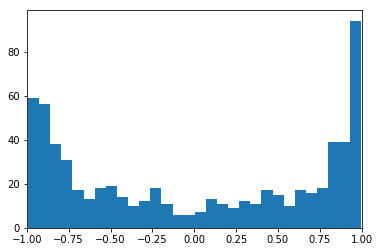

In [56]:
plt.hist(BB.values(),30)
plt.xlim(-1,1)
plt.show()

In [13]:
sorted(BB.items(),key=lambda x:-x[1])[:3],sorted(BB.items(),key=lambda x:x[1])[:3]

([('Occupational Therapists', 0.9989526642923028),
  ('Physical Therapists', 0.9987822078081414),
  ('Speech-Language Pathologists', 0.9959173068658443)],
 [('Couriers and Messengers', -0.9928214105327375),
  ('Computer Operators', -0.9914415092290979),
  ('Meter Readers, Utilities', -0.990536496002425)])

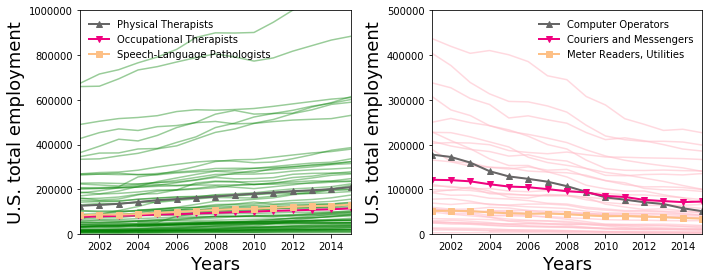

In [17]:
fig = plt.figure(figsize=(10, 4),facecolor='white')
cmap = cm.get_cmap('Accent_r',4)
#
ax = fig.add_subplot(121)
for i in B:
    if BB[i]>0.95:
        x,y=np.array(list(NJ[L[i]].items())).T
        plt.plot(x,y,'g-',alpha=0.4)
n=0
for i,j in zip(['Physical Therapists','Occupational Therapists','Speech-Language Pathologists'],['^','v','s']):
    x,y=np.array(list(NJ[L[i]].items())).T
    plt.plot(x,y,color=cmap(n),linewidth=2,marker=j,label=i)
    n+=1
plt.legend(loc=2,frameon=False,fontsize=10,numpoints=1)
#plt.yscale('log')
plt.xlabel('Years',fontsize=18)
plt.ylabel('U.S. total employment',fontsize=18)
plt.ylim(1000,1*10**6)
plt.xlim(2001,2015)

#
ax = fig.add_subplot(122)
for i in B:
    if BB[i]<-0.95:
        x,y=np.array(list(NJ[L[i]].items())).T
        plt.plot(x,y,color='Pink',alpha=0.6)
n=0
for i,j in zip(['Computer Operators','Couriers and Messengers','Meter Readers, Utilities'],['^','v','s']):
    x,y=np.array(list(NJ[L[i]].items())).T
    plt.plot(x,y,color=cmap(n),linewidth=2,marker=j,label=i)
    n+=1
plt.legend(loc=1,frameon=False,fontsize=10,numpoints=1)
#plt.yscale('log')
plt.xlabel('Years',fontsize=18)
plt.ylabel('U.S. total employment',fontsize=18)
plt.ylim(1000,5*10**5)
plt.xlim(2001,2015)
#

plt.tight_layout()

In [25]:
len(B),len([i for i in B if i in K])

(656, 598)

In [66]:
len([i for i in B if i in K and np.abs(B[i])>0.5])

437

In [65]:
#'''
# construct features
with open('/Users/lingfeiw/Documents/research/people2vec/pygcn-master/data/onet/jobCodeTrend.txt', 'w') as f:
    for j in B:
        if j in K:
            scores=list(K[j].values())+list(J[j].values())
            if B[j]>0.5:
                label=1  #increase
            if B[j]<-0.5:
                label=0  #decrease
            f.write(j+'\t'+'\t'.join(map(str,scores))+'\t'+str(label)+'\n')
    for j in K:
        if j not in B:
            label=2       #no data
        f.write(j+'\t'+'\t'.join(map(str,scores))+'\t'+str(label)+'\n')     
#'''

# Training

In [135]:
path1="/Users/lingfeiw/Documents/research/people2vec/pygcn-master/data/onet/jobCodeTrend.txt"
path2="/Users/lingfeiw/Documents/research/people2vec/pygcn-master/data/onet/jobCites.txt"

d=[]
with open(path1,'r') as f:
    for line in f:
        line=line.strip().split('\t')  
        d.append(line)
d=sorted(d,key=lambda x:x[-1])
#
d1=d[:437]
random.shuffle(d1)
#d[:437]=d1
idx_features_labels=np.array(d1)
features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)
labels = encode_onehot(idx_features_labels[:, -1])#0--->001, 1---->010, 2---->100

NJ=dict((j,n) for n,j in enumerate(idx_features_labels[:, 0]))
JN=dict((v,k) for k,v in NJ.items())

# build graph
idx = np.array([NJ[j] for j in idx_features_labels[:, 0]], dtype=np.int32)
edges=[]
with open(path2,'r') as f:
    for line in f:
        i,j=line.strip().split('\t')  
        if i in NJ and j in NJ:
            edges.append([NJ[i],NJ[j]])

In [136]:

edges=np.array(edges)
adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                    shape=(labels.shape[0], labels.shape[0]),
                    dtype=np.float32)
# build symmetric adjacency matrix
adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
features = normalize(features)
adj = normalize(adj + sp.eye(adj.shape[0]))


idx_train = range(337)
idx_val = range(337,387)
idx_test = range(387, 437)

features = torch.FloatTensor(np.array(features.todense()))
labels = torch.LongTensor(np.where(labels)[1])
adj = sparse_mx_to_torch_sparse_tensor(adj)

idx_train = torch.LongTensor(idx_train)
idx_val = torch.LongTensor(idx_val)
idx_test = torch.LongTensor(idx_test)

In [137]:
class Args:
    def __init__(self):
        self.no_cuda=False
        self.fastmode=False
        self.seed=42
        self.epochs=1000
        self.lr=0.01
        self.weight_decay=5e-4
        self.hidden=16
        self.dropout=0.5

In [138]:
args=Args()
args.cuda = not args.no_cuda and torch.cuda.is_available()
np.random.seed(args.seed)
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)
    
# Model and optimizer
model = GCN(nfeat=features.shape[1],
            nhid=args.hidden,
            nclass=labels.max().item() + 1,
            #nclass=labels.max() + 1,
            dropout=args.dropout)
optimizer = optim.Adam(model.parameters(),
                       lr=args.lr, weight_decay=args.weight_decay)
t_total = time.time()
for epoch in range(args.epochs):
    train(epoch)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

Epoch: 0001 loss_train: 0.8619 acc_train: 0.3472 loss_val: 0.7996 acc_val: 0.3200 time: 0.0091s
Epoch: 0002 loss_train: 0.7920 acc_train: 0.3501 loss_val: 0.7519 acc_val: 0.3200 time: 0.0093s
Epoch: 0003 loss_train: 0.7549 acc_train: 0.3472 loss_val: 0.7124 acc_val: 0.3200 time: 0.0082s
Epoch: 0004 loss_train: 0.7133 acc_train: 0.4036 loss_val: 0.6809 acc_val: 0.6800 time: 0.0084s
Epoch: 0005 loss_train: 0.6713 acc_train: 0.6499 loss_val: 0.6576 acc_val: 0.6800 time: 0.0079s
Epoch: 0006 loss_train: 0.6830 acc_train: 0.5905 loss_val: 0.6424 acc_val: 0.6800 time: 0.0079s
Epoch: 0007 loss_train: 0.6483 acc_train: 0.6469 loss_val: 0.6339 acc_val: 0.6800 time: 0.0078s
Epoch: 0008 loss_train: 0.6597 acc_train: 0.6469 loss_val: 0.6290 acc_val: 0.6800 time: 0.0085s
Epoch: 0009 loss_train: 0.6641 acc_train: 0.6409 loss_val: 0.6268 acc_val: 0.6800 time: 0.0082s
Epoch: 0010 loss_train: 0.6683 acc_train: 0.6439 loss_val: 0.6264 acc_val: 0.6800 time: 0.0166s
Epoch: 0011 loss_train: 0.6549 acc_train

Epoch: 0094 loss_train: 0.5355 acc_train: 0.7151 loss_val: 0.5494 acc_val: 0.7000 time: 0.0090s
Epoch: 0095 loss_train: 0.5268 acc_train: 0.6944 loss_val: 0.5489 acc_val: 0.7600 time: 0.0079s
Epoch: 0096 loss_train: 0.5226 acc_train: 0.7389 loss_val: 0.5484 acc_val: 0.7800 time: 0.0092s
Epoch: 0097 loss_train: 0.5270 acc_train: 0.7211 loss_val: 0.5477 acc_val: 0.7800 time: 0.0081s
Epoch: 0098 loss_train: 0.5266 acc_train: 0.7122 loss_val: 0.5465 acc_val: 0.7800 time: 0.0099s
Epoch: 0099 loss_train: 0.5296 acc_train: 0.7389 loss_val: 0.5441 acc_val: 0.7800 time: 0.0086s
Epoch: 0100 loss_train: 0.5268 acc_train: 0.7478 loss_val: 0.5419 acc_val: 0.7800 time: 0.0104s
Epoch: 0101 loss_train: 0.5142 acc_train: 0.7300 loss_val: 0.5394 acc_val: 0.7800 time: 0.0138s
Epoch: 0102 loss_train: 0.5156 acc_train: 0.7656 loss_val: 0.5374 acc_val: 0.7800 time: 0.0110s
Epoch: 0103 loss_train: 0.5145 acc_train: 0.7418 loss_val: 0.5361 acc_val: 0.7800 time: 0.0119s
Epoch: 0104 loss_train: 0.5112 acc_train

Epoch: 0192 loss_train: 0.4269 acc_train: 0.8101 loss_val: 0.4554 acc_val: 0.8200 time: 0.0115s
Epoch: 0193 loss_train: 0.4108 acc_train: 0.8131 loss_val: 0.4540 acc_val: 0.8200 time: 0.0087s
Epoch: 0194 loss_train: 0.4179 acc_train: 0.7923 loss_val: 0.4505 acc_val: 0.8000 time: 0.0108s
Epoch: 0195 loss_train: 0.4120 acc_train: 0.8101 loss_val: 0.4474 acc_val: 0.8000 time: 0.0078s
Epoch: 0196 loss_train: 0.4183 acc_train: 0.7982 loss_val: 0.4464 acc_val: 0.8000 time: 0.0089s
Epoch: 0197 loss_train: 0.4164 acc_train: 0.7982 loss_val: 0.4463 acc_val: 0.8000 time: 0.0123s
Epoch: 0198 loss_train: 0.4223 acc_train: 0.8012 loss_val: 0.4467 acc_val: 0.8000 time: 0.0103s
Epoch: 0199 loss_train: 0.4263 acc_train: 0.7953 loss_val: 0.4485 acc_val: 0.8200 time: 0.0089s
Epoch: 0200 loss_train: 0.4168 acc_train: 0.8279 loss_val: 0.4490 acc_val: 0.8200 time: 0.0131s
Epoch: 0201 loss_train: 0.4328 acc_train: 0.8012 loss_val: 0.4455 acc_val: 0.8000 time: 0.0135s
Epoch: 0202 loss_train: 0.4056 acc_train

Epoch: 0291 loss_train: 0.4066 acc_train: 0.8042 loss_val: 0.4144 acc_val: 0.8600 time: 0.0107s
Epoch: 0292 loss_train: 0.3849 acc_train: 0.8160 loss_val: 0.4138 acc_val: 0.8600 time: 0.0113s
Epoch: 0293 loss_train: 0.3989 acc_train: 0.8071 loss_val: 0.4152 acc_val: 0.8600 time: 0.0091s
Epoch: 0294 loss_train: 0.4051 acc_train: 0.8101 loss_val: 0.4163 acc_val: 0.9000 time: 0.0103s
Epoch: 0295 loss_train: 0.3861 acc_train: 0.8160 loss_val: 0.4139 acc_val: 0.8600 time: 0.0106s
Epoch: 0296 loss_train: 0.3892 acc_train: 0.8190 loss_val: 0.4121 acc_val: 0.8200 time: 0.0080s
Epoch: 0297 loss_train: 0.3900 acc_train: 0.8249 loss_val: 0.4129 acc_val: 0.8200 time: 0.0109s
Epoch: 0298 loss_train: 0.4174 acc_train: 0.7982 loss_val: 0.4145 acc_val: 0.8600 time: 0.0098s
Epoch: 0299 loss_train: 0.4041 acc_train: 0.7953 loss_val: 0.4177 acc_val: 0.8800 time: 0.0108s
Epoch: 0300 loss_train: 0.3828 acc_train: 0.8398 loss_val: 0.4202 acc_val: 0.9000 time: 0.0126s
Epoch: 0301 loss_train: 0.3887 acc_train

Epoch: 0392 loss_train: 0.3950 acc_train: 0.8131 loss_val: 0.4014 acc_val: 0.8600 time: 0.0108s
Epoch: 0393 loss_train: 0.3830 acc_train: 0.8101 loss_val: 0.4045 acc_val: 0.9000 time: 0.0113s
Epoch: 0394 loss_train: 0.3932 acc_train: 0.8309 loss_val: 0.4057 acc_val: 0.9000 time: 0.0123s
Epoch: 0395 loss_train: 0.3888 acc_train: 0.8160 loss_val: 0.4059 acc_val: 0.9000 time: 0.0089s
Epoch: 0396 loss_train: 0.3789 acc_train: 0.8368 loss_val: 0.4041 acc_val: 0.9000 time: 0.0135s
Epoch: 0397 loss_train: 0.3847 acc_train: 0.8309 loss_val: 0.4037 acc_val: 0.9200 time: 0.0111s
Epoch: 0398 loss_train: 0.3918 acc_train: 0.8160 loss_val: 0.4023 acc_val: 0.8800 time: 0.0090s
Epoch: 0399 loss_train: 0.3900 acc_train: 0.8279 loss_val: 0.4030 acc_val: 0.9200 time: 0.0130s
Epoch: 0400 loss_train: 0.3899 acc_train: 0.8249 loss_val: 0.4063 acc_val: 0.9000 time: 0.0106s
Epoch: 0401 loss_train: 0.3822 acc_train: 0.8309 loss_val: 0.4064 acc_val: 0.9000 time: 0.0085s
Epoch: 0402 loss_train: 0.3888 acc_train

Epoch: 0486 loss_train: 0.3880 acc_train: 0.8071 loss_val: 0.4023 acc_val: 0.9000 time: 0.0099s
Epoch: 0487 loss_train: 0.3768 acc_train: 0.8487 loss_val: 0.3968 acc_val: 0.9000 time: 0.0101s
Epoch: 0488 loss_train: 0.3710 acc_train: 0.8368 loss_val: 0.3931 acc_val: 0.8800 time: 0.0093s
Epoch: 0489 loss_train: 0.3711 acc_train: 0.8279 loss_val: 0.3929 acc_val: 0.8600 time: 0.0077s
Epoch: 0490 loss_train: 0.3805 acc_train: 0.8160 loss_val: 0.3952 acc_val: 0.9000 time: 0.0087s
Epoch: 0491 loss_train: 0.3841 acc_train: 0.8101 loss_val: 0.4001 acc_val: 0.9000 time: 0.0089s
Epoch: 0492 loss_train: 0.3718 acc_train: 0.8516 loss_val: 0.4002 acc_val: 0.9000 time: 0.0120s
Epoch: 0493 loss_train: 0.3747 acc_train: 0.8338 loss_val: 0.3965 acc_val: 0.9000 time: 0.0124s
Epoch: 0494 loss_train: 0.3735 acc_train: 0.8279 loss_val: 0.3928 acc_val: 0.8800 time: 0.0079s
Epoch: 0495 loss_train: 0.3797 acc_train: 0.8309 loss_val: 0.3928 acc_val: 0.8800 time: 0.0121s
Epoch: 0496 loss_train: 0.3711 acc_train

Epoch: 0581 loss_train: 0.3643 acc_train: 0.8338 loss_val: 0.3934 acc_val: 0.9000 time: 0.0086s
Epoch: 0582 loss_train: 0.3757 acc_train: 0.8101 loss_val: 0.3916 acc_val: 0.9000 time: 0.0124s
Epoch: 0583 loss_train: 0.3793 acc_train: 0.8338 loss_val: 0.3900 acc_val: 0.9000 time: 0.0130s
Epoch: 0584 loss_train: 0.3845 acc_train: 0.8131 loss_val: 0.3912 acc_val: 0.9000 time: 0.0092s
Epoch: 0585 loss_train: 0.3738 acc_train: 0.8160 loss_val: 0.3906 acc_val: 0.9000 time: 0.0105s
Epoch: 0586 loss_train: 0.3848 acc_train: 0.8309 loss_val: 0.3891 acc_val: 0.8800 time: 0.0122s
Epoch: 0587 loss_train: 0.3733 acc_train: 0.8338 loss_val: 0.3889 acc_val: 0.8800 time: 0.0175s
Epoch: 0588 loss_train: 0.3675 acc_train: 0.8398 loss_val: 0.3894 acc_val: 0.8800 time: 0.0126s
Epoch: 0589 loss_train: 0.3759 acc_train: 0.8309 loss_val: 0.3902 acc_val: 0.9000 time: 0.0075s
Epoch: 0590 loss_train: 0.3756 acc_train: 0.8249 loss_val: 0.3913 acc_val: 0.9000 time: 0.0080s
Epoch: 0591 loss_train: 0.3741 acc_train

Epoch: 0684 loss_train: 0.3766 acc_train: 0.8131 loss_val: 0.3898 acc_val: 0.9000 time: 0.0228s
Epoch: 0685 loss_train: 0.3759 acc_train: 0.8160 loss_val: 0.3879 acc_val: 0.8800 time: 0.0109s
Epoch: 0686 loss_train: 0.3691 acc_train: 0.8279 loss_val: 0.3882 acc_val: 0.9000 time: 0.0119s
Epoch: 0687 loss_train: 0.3768 acc_train: 0.8190 loss_val: 0.3891 acc_val: 0.9000 time: 0.0123s
Epoch: 0688 loss_train: 0.3612 acc_train: 0.8427 loss_val: 0.3897 acc_val: 0.9000 time: 0.0120s
Epoch: 0689 loss_train: 0.3804 acc_train: 0.8249 loss_val: 0.3916 acc_val: 0.9000 time: 0.0082s
Epoch: 0690 loss_train: 0.3728 acc_train: 0.8279 loss_val: 0.3932 acc_val: 0.9000 time: 0.0143s
Epoch: 0691 loss_train: 0.3725 acc_train: 0.8368 loss_val: 0.3943 acc_val: 0.9000 time: 0.0110s
Epoch: 0692 loss_train: 0.3656 acc_train: 0.8309 loss_val: 0.3924 acc_val: 0.9000 time: 0.0071s
Epoch: 0693 loss_train: 0.3795 acc_train: 0.8249 loss_val: 0.3902 acc_val: 0.9000 time: 0.0073s
Epoch: 0694 loss_train: 0.3820 acc_train

Epoch: 0778 loss_train: 0.3654 acc_train: 0.8190 loss_val: 0.3927 acc_val: 0.9000 time: 0.0131s
Epoch: 0779 loss_train: 0.3787 acc_train: 0.8309 loss_val: 0.3860 acc_val: 0.9000 time: 0.0086s
Epoch: 0780 loss_train: 0.3583 acc_train: 0.8398 loss_val: 0.3828 acc_val: 0.8800 time: 0.0128s
Epoch: 0781 loss_train: 0.3681 acc_train: 0.8190 loss_val: 0.3830 acc_val: 0.8800 time: 0.0134s
Epoch: 0782 loss_train: 0.3608 acc_train: 0.8249 loss_val: 0.3863 acc_val: 0.9000 time: 0.0099s
Epoch: 0783 loss_train: 0.3784 acc_train: 0.8368 loss_val: 0.3978 acc_val: 0.8800 time: 0.0087s
Epoch: 0784 loss_train: 0.3655 acc_train: 0.8368 loss_val: 0.4010 acc_val: 0.8600 time: 0.0121s
Epoch: 0785 loss_train: 0.3816 acc_train: 0.8309 loss_val: 0.3889 acc_val: 0.9000 time: 0.0111s
Epoch: 0786 loss_train: 0.3618 acc_train: 0.8309 loss_val: 0.3828 acc_val: 0.8800 time: 0.0081s
Epoch: 0787 loss_train: 0.3569 acc_train: 0.8279 loss_val: 0.3815 acc_val: 0.8600 time: 0.0120s
Epoch: 0788 loss_train: 0.3679 acc_train

Epoch: 0865 loss_train: 0.3597 acc_train: 0.8427 loss_val: 0.3815 acc_val: 0.8800 time: 0.0127s
Epoch: 0866 loss_train: 0.3638 acc_train: 0.8338 loss_val: 0.3826 acc_val: 0.8800 time: 0.0076s
Epoch: 0867 loss_train: 0.3663 acc_train: 0.8457 loss_val: 0.3876 acc_val: 0.9000 time: 0.0079s
Epoch: 0868 loss_train: 0.3617 acc_train: 0.8249 loss_val: 0.3904 acc_val: 0.9000 time: 0.0101s
Epoch: 0869 loss_train: 0.3668 acc_train: 0.8309 loss_val: 0.3894 acc_val: 0.9000 time: 0.0105s
Epoch: 0870 loss_train: 0.3682 acc_train: 0.8338 loss_val: 0.3886 acc_val: 0.9000 time: 0.0118s
Epoch: 0871 loss_train: 0.3587 acc_train: 0.8279 loss_val: 0.3859 acc_val: 0.9000 time: 0.0134s
Epoch: 0872 loss_train: 0.3681 acc_train: 0.8309 loss_val: 0.3852 acc_val: 0.9000 time: 0.0082s
Epoch: 0873 loss_train: 0.3624 acc_train: 0.8398 loss_val: 0.3851 acc_val: 0.9000 time: 0.0104s
Epoch: 0874 loss_train: 0.3516 acc_train: 0.8487 loss_val: 0.3843 acc_val: 0.8600 time: 0.0109s
Epoch: 0875 loss_train: 0.3614 acc_train

Epoch: 0969 loss_train: 0.3708 acc_train: 0.8279 loss_val: 0.3824 acc_val: 0.8800 time: 0.0084s
Epoch: 0970 loss_train: 0.3527 acc_train: 0.8457 loss_val: 0.3874 acc_val: 0.9000 time: 0.0092s
Epoch: 0971 loss_train: 0.3653 acc_train: 0.8516 loss_val: 0.3941 acc_val: 0.8800 time: 0.0081s
Epoch: 0972 loss_train: 0.3715 acc_train: 0.8338 loss_val: 0.3930 acc_val: 0.8800 time: 0.0106s
Epoch: 0973 loss_train: 0.3776 acc_train: 0.8190 loss_val: 0.3866 acc_val: 0.9000 time: 0.0140s
Epoch: 0974 loss_train: 0.3667 acc_train: 0.8338 loss_val: 0.3835 acc_val: 0.9000 time: 0.0114s
Epoch: 0975 loss_train: 0.3600 acc_train: 0.8398 loss_val: 0.3833 acc_val: 0.8800 time: 0.0121s
Epoch: 0976 loss_train: 0.3629 acc_train: 0.8427 loss_val: 0.3842 acc_val: 0.9000 time: 0.0085s
Epoch: 0977 loss_train: 0.3671 acc_train: 0.8338 loss_val: 0.3857 acc_val: 0.9000 time: 0.0140s
Epoch: 0978 loss_train: 0.3581 acc_train: 0.8516 loss_val: 0.3851 acc_val: 0.9000 time: 0.0184s
Epoch: 0979 loss_train: 0.3561 acc_train

# Graph Attention Network

In [200]:
def Attention(W1,a1):
    in_features=68
    out_features=8
    #W1=model.attentions[0].W
    #a1=model.attentions[0].a
    h = torch.mm(features, W1)
    N = h.size()[0]
    a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], 
                        dim=1).view(N, -1, 2 * out_features)
    leakyrelu = nn.LeakyReLU(.2)
    e = leakyrelu(torch.matmul(a_input, a1).squeeze(2))
    zero_vec = -9e15*torch.ones_like(e)
    attention = torch.where(adj > 0, e, zero_vec)
    attention = F.softmax(attention, dim=1)
    return attention

In [291]:
AS = [Attention(model.attentions[i].W, model.attentions[i].a).data.numpy() for i in range(8)]
M=np.array([np.mean([i[j] for i in AS],axis=0) for j in range(437)])
K=adj.numpy()

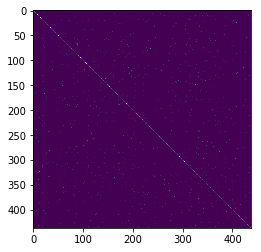

In [278]:
plt.imshow(M)

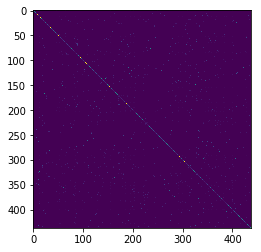

In [283]:
plt.imshow(K)

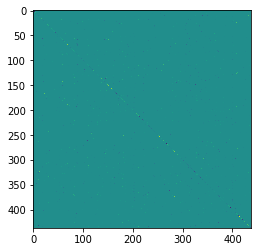

In [284]:
plt.imshow(M-K)

In [314]:
E=defaultdict(lambda:defaultdict(lambda:[]))
for i in range(437):
    for j in range(437):
        if j>i:
            m=M[i,j]
            k=K[i,j]
            if m>0 and k>0:
                E[JN[i]][JN[j]]=m/k

In [315]:
ds=[]
for i in E:
    for j in E[i]:
        ds.append(E[i][j])
        

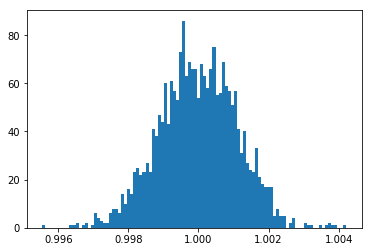

In [318]:
plt.hist(ds,100)
plt.show()

In [171]:
class GraphAttentionLayer(nn.Module):
    """
    Simple GAT layer, similar to https://arxiv.org/abs/1710.10903
    """
    
    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(GraphAttentionLayer, self).__init__()
        self.dropout = dropout
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.concat = concat

        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)
        self.a = nn.Parameter(torch.zeros(size=(2*out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)
        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, input, adj):
        h = torch.mm(input, self.W)
        N = h.size()[0]

        a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], 
                            dim=1).view(N, -1, 2 * self.out_features)
        e = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(2))

        zero_vec = -9e15*torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime = torch.matmul(attention, h)

        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'

class GAT(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout, alpha, nheads):
        """Dense version of GAT."""
        super(GAT, self).__init__()
        self.dropout = dropout

        self.attentions = [GraphAttentionLayer(nfeat, nhid, dropout=dropout, alpha=alpha, concat=True) for _ in range(nheads)]
        for i, attention in enumerate(self.attentions):
            self.add_module('attention_{}'.format(i), attention)

        self.out_att = GraphAttentionLayer(nhid * nheads, nclass, dropout=dropout, alpha=alpha, concat=False)

    def forward(self, x, adj):
        x = F.dropout(x, self.dropout, training=self.training)
        x = torch.cat([att(x, adj) for att in self.attentions], dim=1)
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.elu(self.out_att(x, adj))
        return F.log_softmax(x, dim=1)
    
def normalize_adj(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv_sqrt = np.power(rowsum, -0.5).flatten()
    r_inv_sqrt[np.isinf(r_inv_sqrt)] = 0.
    r_mat_inv_sqrt = sp.diags(r_inv_sqrt)
    return mx.dot(r_mat_inv_sqrt).transpose().dot(r_mat_inv_sqrt)


def normalize_features(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output = model(features, adj)
    loss_train = F.nll_loss(output[idx_train], labels[idx_train])
    acc_train = accuracy(output[idx_train], labels[idx_train])
    loss_train.backward()
    optimizer.step()

    if not args.fastmode:
        # Evaluate validation set performance separately,
        # deactivates dropout during validation run.
        model.eval()
        output = model(features, adj)

    loss_val = F.nll_loss(output[idx_val], labels[idx_val])
    acc_val = accuracy(output[idx_val], labels[idx_val])
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()),
          'time: {:.4f}s'.format(time.time() - t))

    return loss_val.item()

def compute_test():
    model.eval()
    output = model(features, adj)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.data.item()),
          "accuracy= {:.4f}".format(acc_test.data.item()))

In [177]:
path1="/Users/lingfeiw/Documents/research/people2vec/pygcn-master/data/onet/jobCodeTrend.txt"
path2="/Users/lingfeiw/Documents/research/people2vec/pygcn-master/data/onet/jobCites.txt"

d=[]
with open(path1,'r') as f:
    for line in f:
        line=line.strip().split('\t')  
        d.append(line)
d=sorted(d,key=lambda x:x[-1])
#
d1=d[:437]
random.shuffle(d1)
#d[:437]=d1
idx_features_labels=np.array(d1)
features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)
labels = encode_onehot(idx_features_labels[:, -1])

NJ=dict((j,n) for n,j in enumerate(idx_features_labels[:, 0]))

# build graph
idx = np.array([NJ[j] for j in idx_features_labels[:, 0]], dtype=np.int32)
edges=[]
with open(path2,'r') as f:
    for line in f:
        i,j=line.strip().split('\t')  
        if i in NJ and j in NJ:
            edges.append([NJ[i],NJ[j]])
            
edges=np.array(edges)
adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                    shape=(labels.shape[0], labels.shape[0]),
                    dtype=np.float32)

# build symmetric adjacency matrix
adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
features = normalize(features)
adj = normalize(adj + sp.eye(adj.shape[0]))

idx_train = range(337)
idx_val = range(337,387)
idx_test = range(387, 437)

features = torch.FloatTensor(np.array(features.todense()))
labels = torch.LongTensor(np.where(labels)[1])
#adj = sparse_mx_to_torch_sparse_tensor(adj)
adj = torch.FloatTensor(np.array(adj.todense()))

idx_train = torch.LongTensor(idx_train)
idx_val = torch.LongTensor(idx_val)
idx_test = torch.LongTensor(idx_test)

In [176]:
class Args:
    def __init__(self):
        self.no_cuda=False
        self.fastmode=False
        self.seed=72
        self.epochs=2000
        self.lr=5e-3
        self.weight_decay=5e-4
        self.hidden=8
        self.nb_heads=8
        self.dropout=0.6
        self.alpha=0.2
        self.patience=100
args=Args()
args.cuda = not args.no_cuda and torch.cuda.is_available()

random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

# Model and optimizer
model = GAT(nfeat=features.shape[1], 
            nhid=args.hidden, 
            nclass=int(labels.max()) + 1, 
            dropout=args.dropout, 
            nheads=args.nb_heads, 
            alpha=args.alpha)

optimizer = optim.Adam(model.parameters(), 
                       lr=args.lr, 
                       weight_decay=args.weight_decay)

In [178]:
# Train model
t_total = time.time()
loss_values = []
bad_counter = 0
best = args.epochs + 1
best_epoch = 0
for epoch in range(args.epochs):
    loss_values.append(train(epoch))

    torch.save(model.state_dict(), '{}.pkl'.format(epoch))
    if loss_values[-1] < best:
        best = loss_values[-1]
        best_epoch = epoch
        bad_counter = 0
    else:
        bad_counter += 1

    if bad_counter == args.patience:
        break

    files = glob.glob('*.pkl')
    for file in files:
        epoch_nb = int(file.split('.')[0])
        if epoch_nb < best_epoch:
            os.remove(file)

files = glob.glob('*.pkl')
for file in files:
    epoch_nb = int(file.split('.')[0])
    if epoch_nb > best_epoch:
        os.remove(file)

print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

# Restore best model
print('Loading {}th epoch'.format(best_epoch))
model.load_state_dict(torch.load('{}.pkl'.format(best_epoch)))

# Testing
compute_test()

Epoch: 0001 loss_train: 0.7140 acc_train: 0.3976 loss_val: 0.6824 acc_val: 0.7400 time: 0.8159s
Epoch: 0002 loss_train: 0.6848 acc_train: 0.6469 loss_val: 0.6636 acc_val: 0.7400 time: 0.8681s
Epoch: 0003 loss_train: 0.6890 acc_train: 0.6024 loss_val: 0.6477 acc_val: 0.7400 time: 0.8571s
Epoch: 0004 loss_train: 0.6713 acc_train: 0.6469 loss_val: 0.6345 acc_val: 0.7400 time: 0.7289s
Epoch: 0005 loss_train: 0.6580 acc_train: 0.6528 loss_val: 0.6231 acc_val: 0.7400 time: 0.7397s
Epoch: 0006 loss_train: 0.6679 acc_train: 0.6409 loss_val: 0.6140 acc_val: 0.7400 time: 0.7843s
Epoch: 0007 loss_train: 0.6720 acc_train: 0.6617 loss_val: 0.6069 acc_val: 0.7400 time: 0.7347s
Epoch: 0008 loss_train: 0.6548 acc_train: 0.6558 loss_val: 0.6012 acc_val: 0.7400 time: 0.7213s
Epoch: 0009 loss_train: 0.6431 acc_train: 0.6588 loss_val: 0.5963 acc_val: 0.7400 time: 0.7243s
Epoch: 0010 loss_train: 0.6487 acc_train: 0.6528 loss_val: 0.5924 acc_val: 0.7400 time: 0.7299s
Epoch: 0011 loss_train: 0.6569 acc_train

Epoch: 0087 loss_train: 0.5586 acc_train: 0.7240 loss_val: 0.4778 acc_val: 0.8200 time: 0.7428s
Epoch: 0088 loss_train: 0.5750 acc_train: 0.7003 loss_val: 0.4755 acc_val: 0.8200 time: 0.7268s
Epoch: 0089 loss_train: 0.5530 acc_train: 0.7418 loss_val: 0.4720 acc_val: 0.8200 time: 0.7219s
Epoch: 0090 loss_train: 0.5481 acc_train: 0.7389 loss_val: 0.4689 acc_val: 0.8200 time: 0.7309s
Epoch: 0091 loss_train: 0.5475 acc_train: 0.7418 loss_val: 0.4659 acc_val: 0.8200 time: 0.7252s
Epoch: 0092 loss_train: 0.5512 acc_train: 0.7329 loss_val: 0.4631 acc_val: 0.8200 time: 0.7231s
Epoch: 0093 loss_train: 0.5406 acc_train: 0.7300 loss_val: 0.4613 acc_val: 0.8200 time: 0.7243s
Epoch: 0094 loss_train: 0.5560 acc_train: 0.7418 loss_val: 0.4602 acc_val: 0.8200 time: 0.7307s
Epoch: 0095 loss_train: 0.5651 acc_train: 0.7181 loss_val: 0.4601 acc_val: 0.8200 time: 0.7130s
Epoch: 0096 loss_train: 0.5860 acc_train: 0.7211 loss_val: 0.4598 acc_val: 0.8200 time: 0.7295s
Epoch: 0097 loss_train: 0.5657 acc_train

Epoch: 0173 loss_train: 0.5142 acc_train: 0.7596 loss_val: 0.3963 acc_val: 0.8200 time: 0.7410s
Epoch: 0174 loss_train: 0.5183 acc_train: 0.7804 loss_val: 0.3966 acc_val: 0.8200 time: 0.7240s
Epoch: 0175 loss_train: 0.5428 acc_train: 0.7537 loss_val: 0.3977 acc_val: 0.8200 time: 0.7428s
Epoch: 0176 loss_train: 0.5022 acc_train: 0.7864 loss_val: 0.3990 acc_val: 0.8200 time: 0.7247s
Epoch: 0177 loss_train: 0.5434 acc_train: 0.7626 loss_val: 0.4015 acc_val: 0.8400 time: 0.7358s
Epoch: 0178 loss_train: 0.5229 acc_train: 0.7774 loss_val: 0.4022 acc_val: 0.8400 time: 0.7257s
Epoch: 0179 loss_train: 0.4986 acc_train: 0.7834 loss_val: 0.4019 acc_val: 0.8400 time: 0.7392s
Epoch: 0180 loss_train: 0.5128 acc_train: 0.7685 loss_val: 0.4006 acc_val: 0.8400 time: 0.7181s
Epoch: 0181 loss_train: 0.5034 acc_train: 0.7448 loss_val: 0.4005 acc_val: 0.8400 time: 0.7325s
Epoch: 0182 loss_train: 0.5078 acc_train: 0.7715 loss_val: 0.3994 acc_val: 0.8200 time: 0.7202s
Epoch: 0183 loss_train: 0.4905 acc_train

Epoch: 0259 loss_train: 0.5023 acc_train: 0.7418 loss_val: 0.3795 acc_val: 0.8400 time: 0.7339s
Epoch: 0260 loss_train: 0.5232 acc_train: 0.7567 loss_val: 0.3819 acc_val: 0.8400 time: 0.7381s
Epoch: 0261 loss_train: 0.4983 acc_train: 0.7537 loss_val: 0.3831 acc_val: 0.8400 time: 0.7425s
Epoch: 0262 loss_train: 0.4928 acc_train: 0.7507 loss_val: 0.3834 acc_val: 0.8400 time: 0.7225s
Epoch: 0263 loss_train: 0.5160 acc_train: 0.7774 loss_val: 0.3816 acc_val: 0.8400 time: 0.7302s
Epoch: 0264 loss_train: 0.5344 acc_train: 0.7596 loss_val: 0.3796 acc_val: 0.8400 time: 0.7416s
Epoch: 0265 loss_train: 0.4926 acc_train: 0.8071 loss_val: 0.3779 acc_val: 0.8400 time: 0.7225s
Epoch: 0266 loss_train: 0.4959 acc_train: 0.7804 loss_val: 0.3767 acc_val: 0.8400 time: 0.7146s
Epoch: 0267 loss_train: 0.5260 acc_train: 0.7418 loss_val: 0.3757 acc_val: 0.8200 time: 0.7024s
Epoch: 0268 loss_train: 0.4876 acc_train: 0.7656 loss_val: 0.3753 acc_val: 0.8200 time: 0.7354s
Epoch: 0269 loss_train: 0.5153 acc_train

Epoch: 0345 loss_train: 0.4612 acc_train: 0.8042 loss_val: 0.3737 acc_val: 0.8400 time: 0.7068s
Epoch: 0346 loss_train: 0.4648 acc_train: 0.8190 loss_val: 0.3710 acc_val: 0.8200 time: 0.7408s
Epoch: 0347 loss_train: 0.5270 acc_train: 0.7626 loss_val: 0.3701 acc_val: 0.8200 time: 0.7206s
Epoch: 0348 loss_train: 0.4983 acc_train: 0.7715 loss_val: 0.3696 acc_val: 0.8200 time: 0.7168s
Epoch: 0349 loss_train: 0.5019 acc_train: 0.7893 loss_val: 0.3693 acc_val: 0.8200 time: 0.7305s
Epoch: 0350 loss_train: 0.5029 acc_train: 0.7596 loss_val: 0.3692 acc_val: 0.8200 time: 0.8209s
Epoch: 0351 loss_train: 0.5001 acc_train: 0.7596 loss_val: 0.3694 acc_val: 0.8200 time: 0.7055s
Epoch: 0352 loss_train: 0.5092 acc_train: 0.7656 loss_val: 0.3702 acc_val: 0.8200 time: 0.7659s
Epoch: 0353 loss_train: 0.4810 acc_train: 0.7596 loss_val: 0.3724 acc_val: 0.8400 time: 0.7837s
Epoch: 0354 loss_train: 0.5092 acc_train: 0.7774 loss_val: 0.3749 acc_val: 0.8400 time: 0.7346s
Epoch: 0355 loss_train: 0.5062 acc_train

Epoch: 0431 loss_train: 0.5074 acc_train: 0.7864 loss_val: 0.3715 acc_val: 0.8400 time: 0.7427s
Epoch: 0432 loss_train: 0.4855 acc_train: 0.7923 loss_val: 0.3762 acc_val: 0.8400 time: 0.7253s
Epoch: 0433 loss_train: 0.4796 acc_train: 0.7923 loss_val: 0.3793 acc_val: 0.8400 time: 0.7402s
Epoch: 0434 loss_train: 0.4862 acc_train: 0.7596 loss_val: 0.3810 acc_val: 0.8400 time: 0.7365s
Epoch: 0435 loss_train: 0.5225 acc_train: 0.7507 loss_val: 0.3821 acc_val: 0.8400 time: 0.7215s
Epoch: 0436 loss_train: 0.5210 acc_train: 0.7507 loss_val: 0.3824 acc_val: 0.8400 time: 0.7318s
Epoch: 0437 loss_train: 0.4867 acc_train: 0.7745 loss_val: 0.3798 acc_val: 0.8400 time: 0.7054s
Epoch: 0438 loss_train: 0.4828 acc_train: 0.7864 loss_val: 0.3755 acc_val: 0.8400 time: 0.7132s
Epoch: 0439 loss_train: 0.4848 acc_train: 0.7923 loss_val: 0.3711 acc_val: 0.8400 time: 0.7204s
Epoch: 0440 loss_train: 0.4630 acc_train: 0.7982 loss_val: 0.3672 acc_val: 0.8200 time: 0.7151s
Epoch: 0441 loss_train: 0.4625 acc_train

Epoch: 0517 loss_train: 0.4773 acc_train: 0.7834 loss_val: 0.3637 acc_val: 0.8200 time: 0.7345s
Epoch: 0518 loss_train: 0.4988 acc_train: 0.7864 loss_val: 0.3635 acc_val: 0.8400 time: 0.7270s
Epoch: 0519 loss_train: 0.4971 acc_train: 0.7656 loss_val: 0.3637 acc_val: 0.8200 time: 0.7379s
Epoch: 0520 loss_train: 0.4962 acc_train: 0.7774 loss_val: 0.3645 acc_val: 0.8200 time: 0.7411s
Epoch: 0521 loss_train: 0.4905 acc_train: 0.7953 loss_val: 0.3660 acc_val: 0.8200 time: 0.7328s
Epoch: 0522 loss_train: 0.4930 acc_train: 0.7953 loss_val: 0.3675 acc_val: 0.8400 time: 0.7246s
Epoch: 0523 loss_train: 0.4790 acc_train: 0.7715 loss_val: 0.3693 acc_val: 0.8400 time: 0.7440s
Epoch: 0524 loss_train: 0.4907 acc_train: 0.7953 loss_val: 0.3704 acc_val: 0.8400 time: 0.7232s
Epoch: 0525 loss_train: 0.4781 acc_train: 0.7864 loss_val: 0.3716 acc_val: 0.8400 time: 0.7316s
Epoch: 0526 loss_train: 0.4852 acc_train: 0.8131 loss_val: 0.3717 acc_val: 0.8400 time: 0.7212s
Epoch: 0527 loss_train: 0.4743 acc_train

Epoch: 0603 loss_train: 0.5069 acc_train: 0.7359 loss_val: 0.3618 acc_val: 0.8200 time: 0.7159s
Epoch: 0604 loss_train: 0.4705 acc_train: 0.7804 loss_val: 0.3638 acc_val: 0.8400 time: 0.7366s
Epoch: 0605 loss_train: 0.4881 acc_train: 0.7804 loss_val: 0.3654 acc_val: 0.8400 time: 0.7463s
Epoch: 0606 loss_train: 0.4798 acc_train: 0.7478 loss_val: 0.3663 acc_val: 0.8400 time: 0.7270s
Epoch: 0607 loss_train: 0.4585 acc_train: 0.7864 loss_val: 0.3670 acc_val: 0.8400 time: 0.7268s
Epoch: 0608 loss_train: 0.5048 acc_train: 0.7804 loss_val: 0.3660 acc_val: 0.8400 time: 0.7243s
Epoch: 0609 loss_train: 0.4848 acc_train: 0.7864 loss_val: 0.3642 acc_val: 0.8400 time: 0.7351s
Epoch: 0610 loss_train: 0.4992 acc_train: 0.7715 loss_val: 0.3633 acc_val: 0.8400 time: 0.7143s
Epoch: 0611 loss_train: 0.5032 acc_train: 0.7685 loss_val: 0.3629 acc_val: 0.8400 time: 0.7189s
Epoch: 0612 loss_train: 0.4647 acc_train: 0.8071 loss_val: 0.3629 acc_val: 0.8400 time: 0.7217s
Epoch: 0613 loss_train: 0.4917 acc_train

Epoch: 0689 loss_train: 0.4790 acc_train: 0.7626 loss_val: 0.3665 acc_val: 0.8400 time: 0.7272s
Epoch: 0690 loss_train: 0.4781 acc_train: 0.7834 loss_val: 0.3703 acc_val: 0.8400 time: 0.7339s
Epoch: 0691 loss_train: 0.4933 acc_train: 0.7685 loss_val: 0.3749 acc_val: 0.8400 time: 0.7355s
Epoch: 0692 loss_train: 0.5209 acc_train: 0.7804 loss_val: 0.3756 acc_val: 0.8400 time: 0.7347s
Epoch: 0693 loss_train: 0.4845 acc_train: 0.7834 loss_val: 0.3731 acc_val: 0.8400 time: 0.7214s
Epoch: 0694 loss_train: 0.4858 acc_train: 0.7715 loss_val: 0.3700 acc_val: 0.8400 time: 0.7148s
Epoch: 0695 loss_train: 0.4763 acc_train: 0.7834 loss_val: 0.3655 acc_val: 0.8400 time: 0.7391s
Epoch: 0696 loss_train: 0.4561 acc_train: 0.8012 loss_val: 0.3617 acc_val: 0.8200 time: 0.7125s
Epoch: 0697 loss_train: 0.4964 acc_train: 0.7448 loss_val: 0.3597 acc_val: 0.8200 time: 0.7500s
Epoch: 0698 loss_train: 0.4850 acc_train: 0.7656 loss_val: 0.3591 acc_val: 0.8400 time: 0.7279s
Epoch: 0699 loss_train: 0.5177 acc_train

In [182]:
model

GAT(
  (attention_0): GraphAttentionLayer (68 -> 8)
  (attention_1): GraphAttentionLayer (68 -> 8)
  (attention_2): GraphAttentionLayer (68 -> 8)
  (attention_3): GraphAttentionLayer (68 -> 8)
  (attention_4): GraphAttentionLayer (68 -> 8)
  (attention_5): GraphAttentionLayer (68 -> 8)
  (attention_6): GraphAttentionLayer (68 -> 8)
  (attention_7): GraphAttentionLayer (68 -> 8)
  (out_att): GraphAttentionLayer (64 -> 2)
)

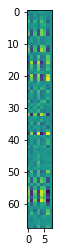

In [181]:
plt.imshow(model.attentions[0].W.data.numpy())
plt.show()

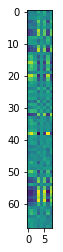

In [183]:
plt.imshow(model.attentions[1].W.data.numpy())
plt.show()

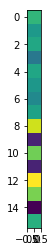

In [184]:
plt.imshow(model.attentions[0].a.data.numpy())
plt.show()

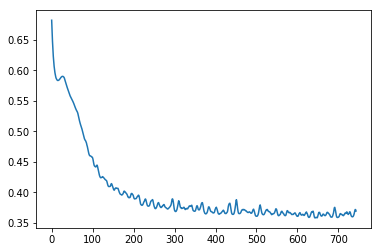

In [185]:
plt.plot(loss_values)